### EDA on Process data

First we will import the packages we will use in this notebook:

In [43]:
import pandas as pd
from datetime import datetime as dt
import time
import matplotlib.pyplot as plt
import numpy as np
from sys import getsizeof as ram

Define useful functions and variables for use throughout the workbook.

In [37]:
start = 0
def dtn():
    global start
    start = dt.now()
def end():
    return str(dt.now()-start)
def gen_end():
    stop = end()
    print("Completed in :"+stop)

Next we will read in our Process Data, available on the web or locally:

In [6]:
try:
    print("Looking for local copy of data...")
    dtn()
    df_p = pd.read_csv("G:/Users/Gabriel/Documents/Education/UoB/GitHubDesktop/Advanced-Cyber-Analytics-for-Attack-Detection/Data/Process data.gz",compression="gzip")
    stop = end()
    print("Data fetched locally in "+stop)
except OSError as e:
    if e.errno == 2:
        print("No Local data found. Importing from the web.")
        dtn()
        df_p = pd.read_csv("https://www.dropbox.com/s/c065rcq72abzm0s/Process_data.gz?dl=1",compression="gzip")
        stop = end()
        print("Data fetched from web in "+stop)
    else:
        print(e)

Looking for local copy of data...
Data fetched locally in 0:01:07.075346


In [7]:
df_p.head()

,Unnamed: 0,UserName,Device,ProcessName,ParentProcessName,DailyCount
0,0,Comp748297$,Comp748297,Proc391839.exe,Proc387473,1
1,1,Comp563664$,Comp563664,rundll32.exe,services,1
2,2,User607396,Comp609111,Proc417435.exe,Proc417435,1
3,3,Comp641702$,Comp641702,Proc249569.exe,services,1
4,4,Comp157389$,Comp157389,Proc402696.exe,services,1


In [8]:
df_p.tail()

,Unnamed: 0,UserName,Device,ProcessName,ParentProcessName,DailyCount
55981613,251545,Comp738970$,Comp738970,Proc207472.exe,svchost,2
55981614,251546,User925794,Comp097857,cmd.exe,Proc174492,2
55981615,251547,Comp996714$,Comp996714,Proc612297.exe,services,5
55981616,251548,Comp391736$,Comp391736,rundll32.exe,Proc247259,2
55981617,251549,Comp769777$,Comp769777,rundll32.exe,rundll32,3


In [9]:
def data_qual(df):
    global data_quality_report
    #DataFrame with columns
    columns = pd.DataFrame(list(df.columns.values[1:]))

    #DataFrame with data types
    data_types = pd.DataFrame(df.dtypes, columns=['Data Type'])

    #DataFrame with Count
    data_count = pd.DataFrame(df.count(), columns=['Count'])

    #DataFrame with unique values
    unique_value_counts = pd.DataFrame(columns=['Unique Values'])
    for v in list(df.columns.values):
        unique_value_counts.loc[v] = [df[v].nunique()]

    missing_data_counts = pd.DataFrame(df.isnull().sum(), columns=['Missing Values'])
    data_quality_report = data_types.join(data_count).join(unique_value_counts).join(missing_data_counts)
    print('Data Quality Report')

In [10]:
data_qual(df_p)
print("Process Data")
data_quality_report

Data Quality Report
Process Data


,Data Type,Count,Unique Values,Missing Values
Unnamed: 0,int64,55981618,1213395,0
UserName,object,55981618,25320,0
Device,object,55981618,13476,0
ProcessName,object,55981618,25373,0
ParentProcessName,object,55981618,12226,0
DailyCount,int64,55981618,15374,0


In [11]:
df_p = df_p.drop(df_p.columns[0],axis=1)

In [12]:
df_p.head()

,UserName,Device,ProcessName,ParentProcessName,DailyCount
0,Comp748297$,Comp748297,Proc391839.exe,Proc387473,1
1,Comp563664$,Comp563664,rundll32.exe,services,1
2,User607396,Comp609111,Proc417435.exe,Proc417435,1
3,Comp641702$,Comp641702,Proc249569.exe,services,1
4,Comp157389$,Comp157389,Proc402696.exe,services,1


In [13]:
x = []
for i in df_p.columns:
    if i == "DailyCount":
        global df_int
        df_int = df = df_p[str(i)].describe()
    else:
        df = df_p[str(i)].describe()
        x.append(df)
df_desc = pd.concat(x,axis=1)

In [14]:
df_desc

,UserName,Device,ProcessName,ParentProcessName
count,55981618,55981618,55981618,55981618
unique,25320,13476,25373,12226
top,Scanner,EnterpriseAppServer,rundll32.exe,services
freq,255383,451831,2325974,12633664


In [15]:
df_int

count    5.598162e+07
mean     2.602635e+01
std      1.234955e+03
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      5.000000e+00
max      9.025670e+05
Name: DailyCount, dtype: float64

In [16]:
x = ["UserName","Device","ProcessName","ParentProcessName"]
counts = []
for i in x:
    z = df_p.groupby(i).size().sort_values(ascending=False)
    z = pd.DataFrame(z)
    z.reset_index(level=0, inplace=True)
    z.columns = [i,'Count']
    counts.append(z)

In [17]:
counts[0].head(20)

,UserName,Count
0,Scanner,255383
1,User272607,73934
2,EnterpriseAppServer$,38552
3,Administrator,29443
4,User414014,18593
5,AppService,17675
6,User724397,16334
7,Comp916004$,11648
8,Comp943585$,10467
9,User703614,10107


In [18]:
counts[1].head(20)

,Device,Count
0,EnterpriseAppServer,451831
1,Comp149394,28007
2,Comp460411,26771
3,Comp978490,25866
4,Comp897269,24757
5,Comp291378,24704
6,Comp420961,24387
7,Comp133838,23279
8,Comp664214,22566
9,Comp354553,21900


In [19]:
counts[2].head(20)

,ProcessName,Count
0,rundll32.exe,2325974
1,cscript.exe,1687233
2,Proc857443.exe,1644561
3,Proc364675.exe,1499525
4,conhost.exe,1231137
5,dllhost.exe,969474
6,wmiprvse.exe,963022
7,taskhost.exe,938684
8,svchost.exe,866240
9,Proc453954.exe,865180


In [20]:
counts[3].head(20)

,ParentProcessName,Count
0,services,12633664
1,svchost,5742175
2,None,4343007
3,Proc089893,3499148
4,taskeng,2496930
5,Proc247259,2361635
6,Proc443607,1415832
7,Proc442764,1336381
8,cmd,1275235
9,winlogon,1240798


In [21]:
for i in range(0,4):
    print(counts[i].columns[0])
    print("Length = "+str(len(counts[i])))
    print("")

UserName
Length = 25320

Device
Length = 13476

ProcessName
Length = 25373

ParentProcessName
Length = 12226



In [22]:
counts[0].loc[:,"Count"]
i = 0
x = counts[0].loc[:,"Count"][0]
while x > 100:
    x = counts[0].loc[:,"Count"][i]
    i = i + 1
print(i)

23047


In [23]:
counts[0].loc[:,"Count"]
i = 0
x = counts[0].loc[:,"Count"][0]
while x > 1000:
    x = counts[0].loc[:,"Count"][i]
    i = i + 1
print(i)

17999


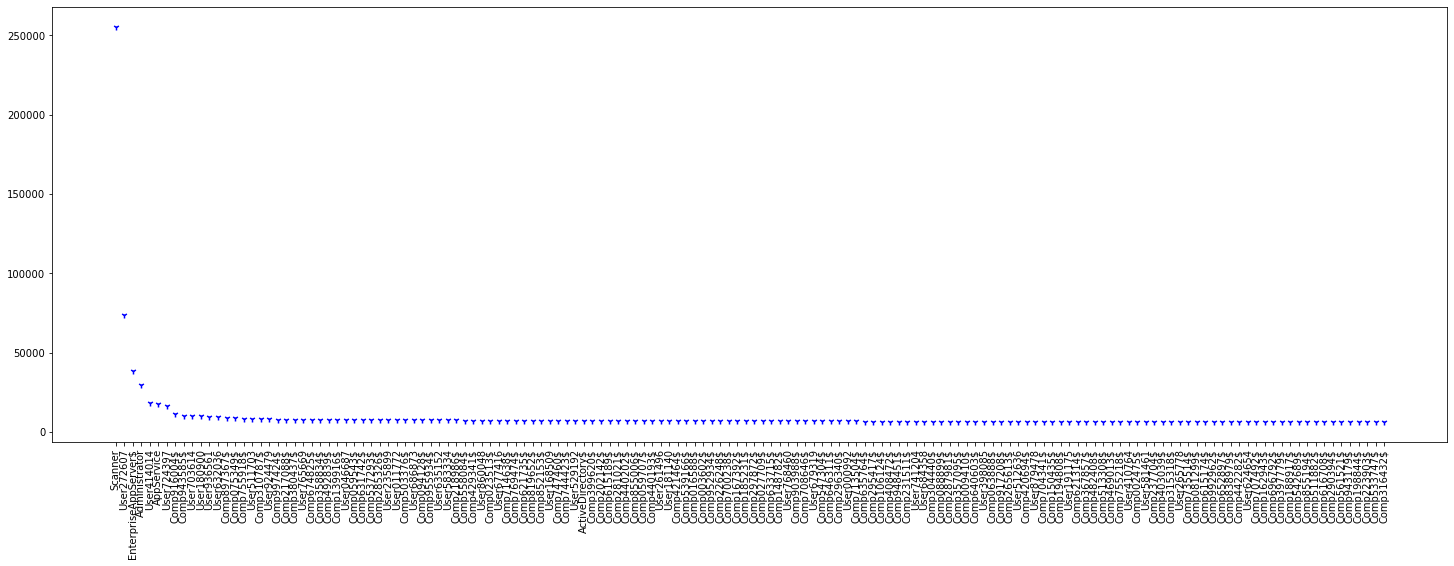

In [53]:
x=counts[0].loc[:,"UserName"].head(150)
y=counts[0].loc[:,"Count"].head(150)

plt.rcParams["figure.figsize"] = (25,8)
plt.scatter(x,y,marker="1",c="Blue")
plt.xticks(rotation=90)
plt.show()

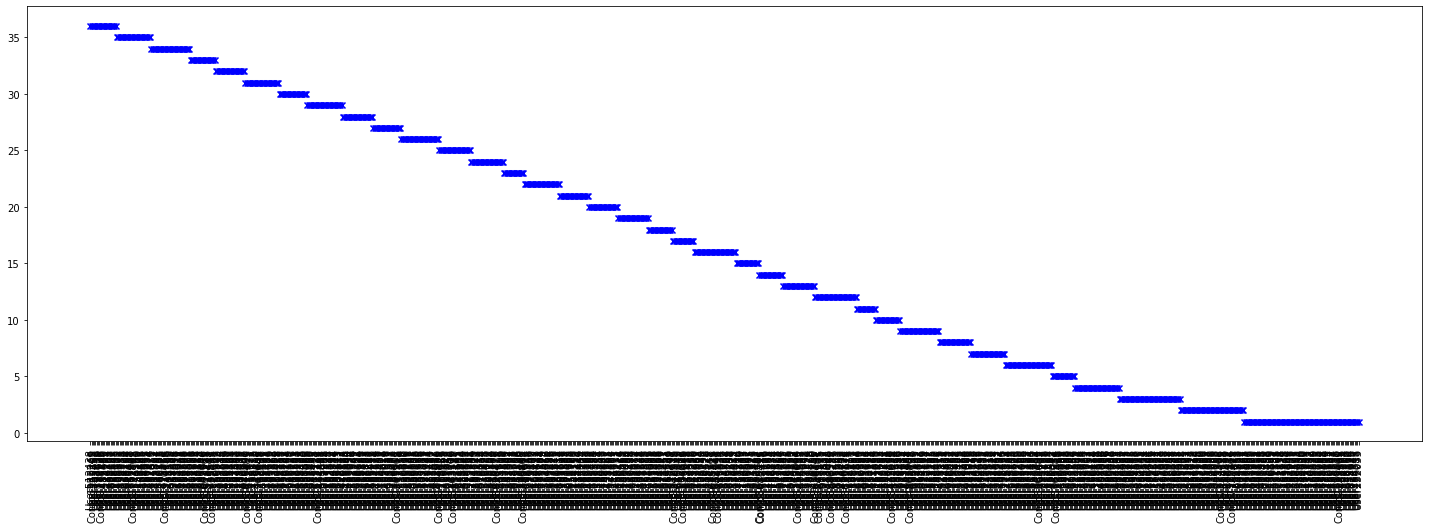

Completed in :0:00:32.350983


In [57]:
dtn()
x=counts[0].loc[:,"UserName"].tail(1000)
y=counts[0].loc[:,"Count"].tail(1000)

plt.rcParams["figure.figsize"] = (25,8)
plt.scatter(x,y,marker="x",c="Blue")
plt.xticks(rotation=90)
plt.show()
gen_end()

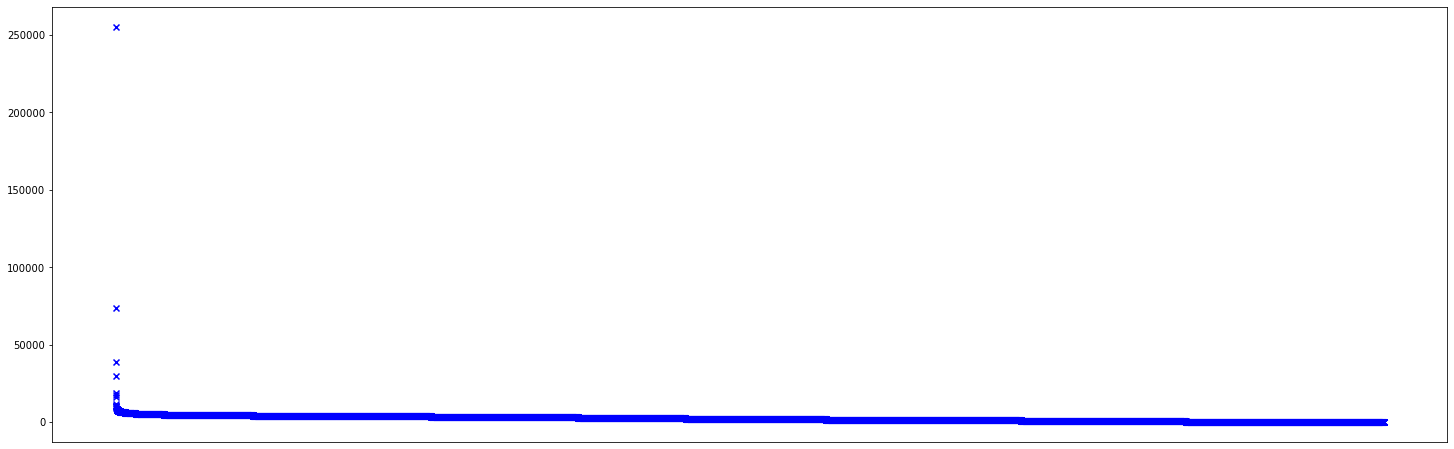

Completed in :0:00:44.866747


In [58]:
dtn()
x=counts[0].loc[:,"UserName"]
y=counts[0].loc[:,"Count"]

plt.rcParams["figure.figsize"] = (25,8)
plt.scatter(x,y,marker="x",c="Blue")
plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.show()
gen_end()

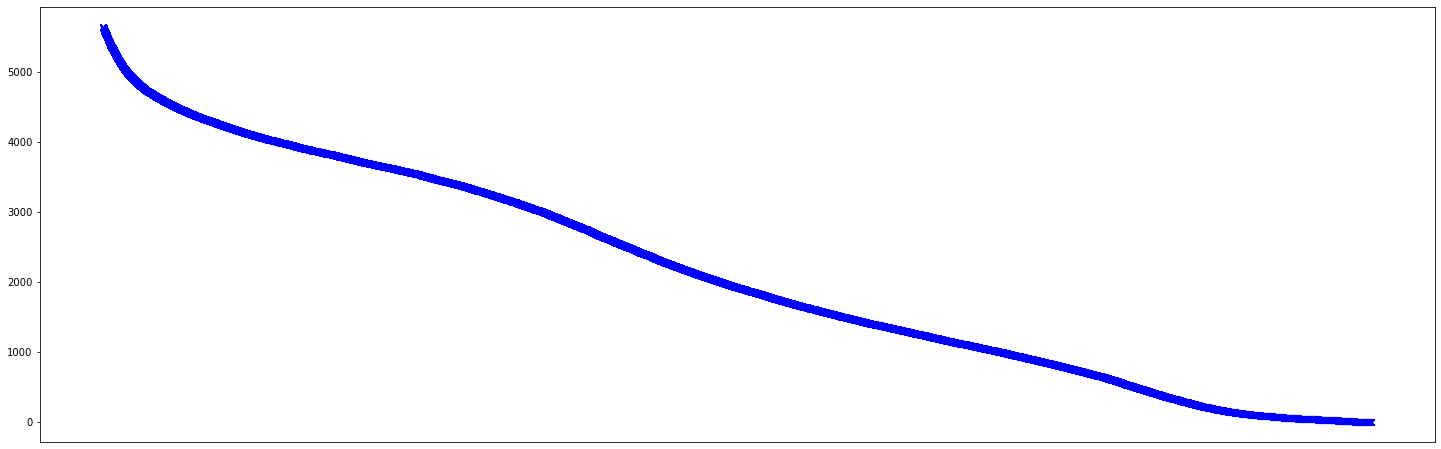

Completed in :0:00:47.014027


In [63]:
dtn()
x=counts[0].loc[:,"UserName"].tail(25000)
y=counts[0].loc[:,"Count"].tail(25000)

plt.rcParams["figure.figsize"] = (25,8)
plt.scatter(x,y,marker="x",c="Blue")
plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.show()
gen_end()

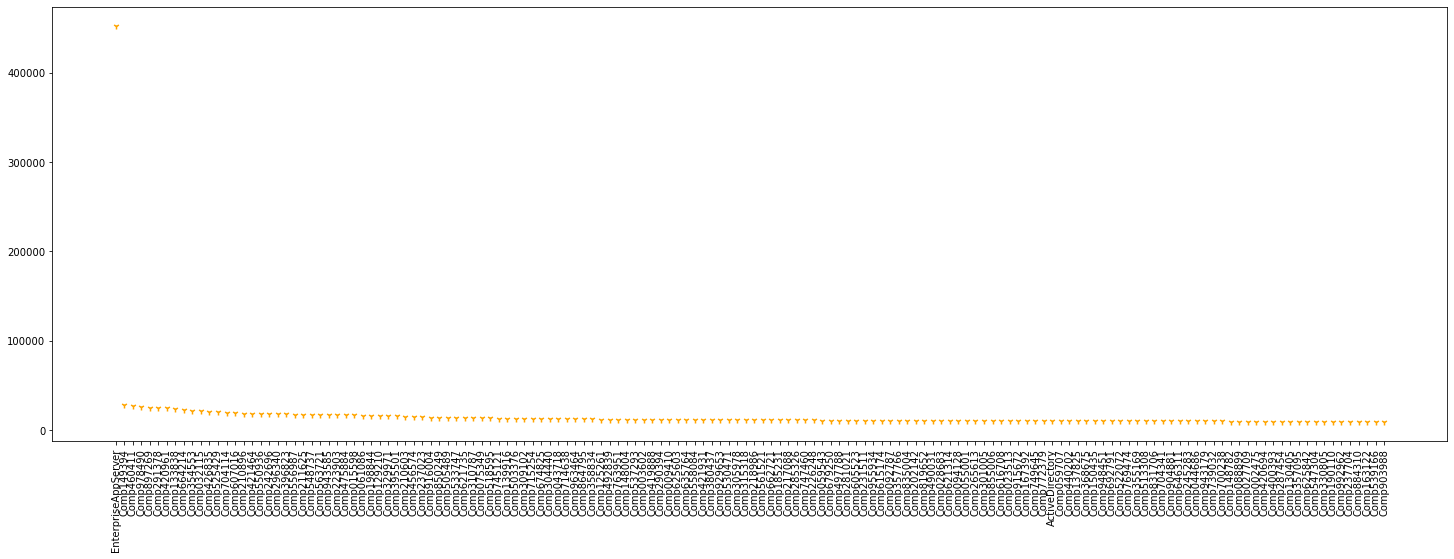

In [52]:
x=counts[1].loc[:,"Device"].head(150)
y=counts[1].loc[:,"Count"].head(150)

plt.rcParams["figure.figsize"] = (25,8)
plt.scatter(x,y,marker="1",c="Orange")
plt.xticks(rotation=90)
plt.show()

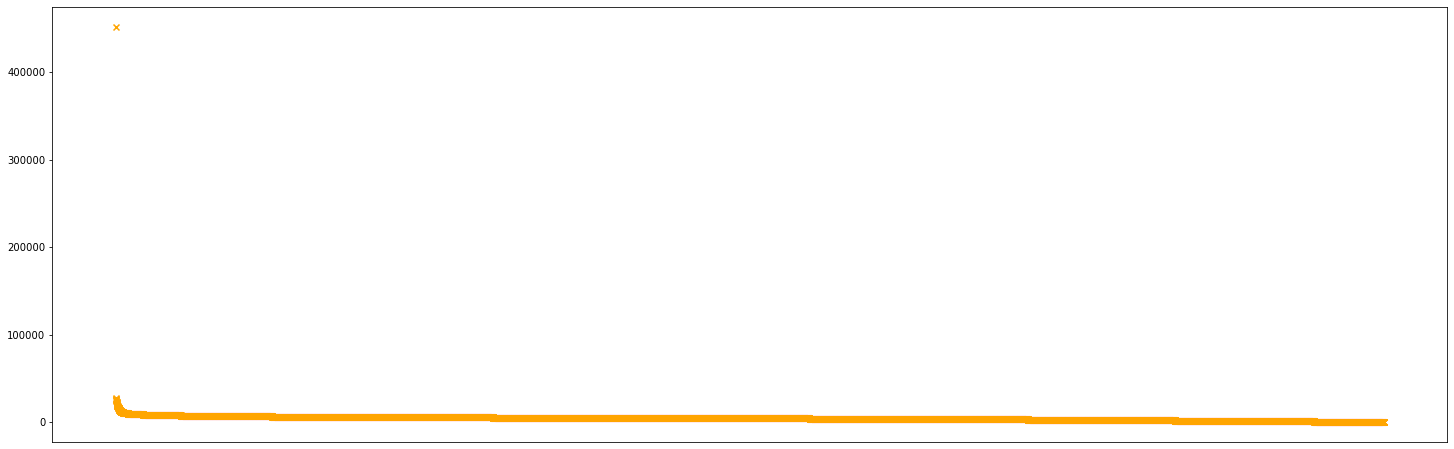

Completed in :0:00:24.929087


In [64]:
dtn()
x=counts[1].loc[:,"Device"]
y=counts[1].loc[:,"Count"]

plt.rcParams["figure.figsize"] = (25,8)
plt.scatter(x,y,marker="x",c="Orange")
plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.show()

gen_end()

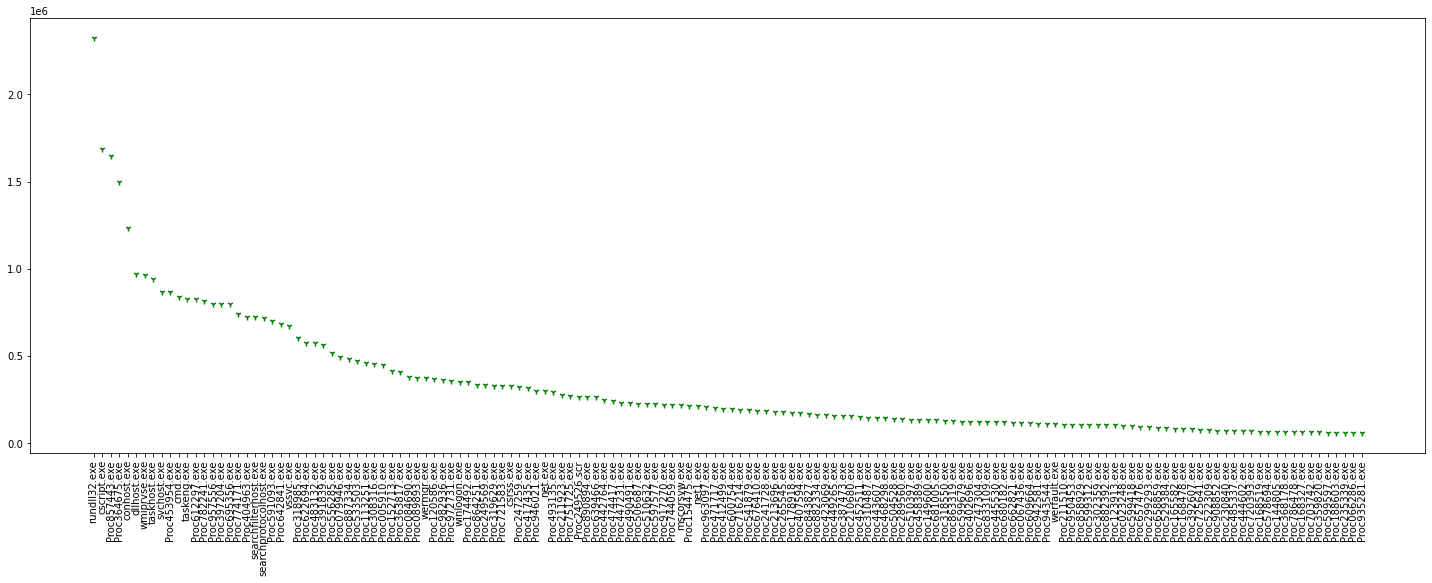

In [51]:
x=counts[2].loc[:,"ProcessName"].head(150)
y=counts[2].loc[:,"Count"].head(150)

plt.rcParams["figure.figsize"] = (25,8)
plt.scatter(x,y,marker="1",c="Green")
plt.xticks(rotation=90)
plt.show()

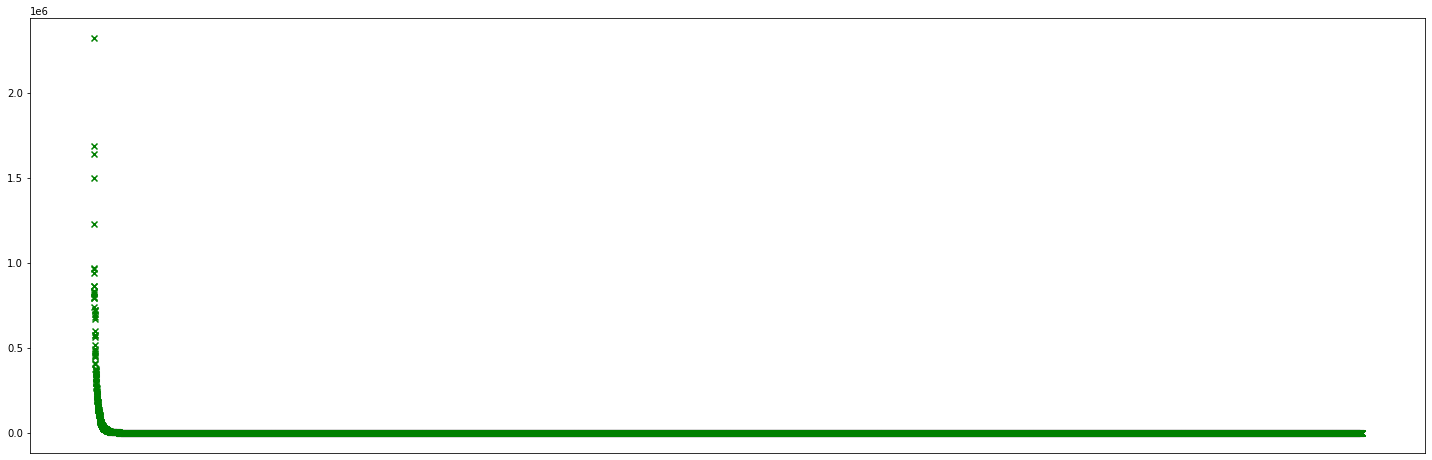

Completed in :0:00:48.350512


In [65]:
dtn()
x=counts[2].loc[:,"ProcessName"]
y=counts[2].loc[:,"Count"]

plt.rcParams["figure.figsize"] = (25,8)
plt.scatter(x,y,marker="x",c="Green")
plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.show()

gen_end()

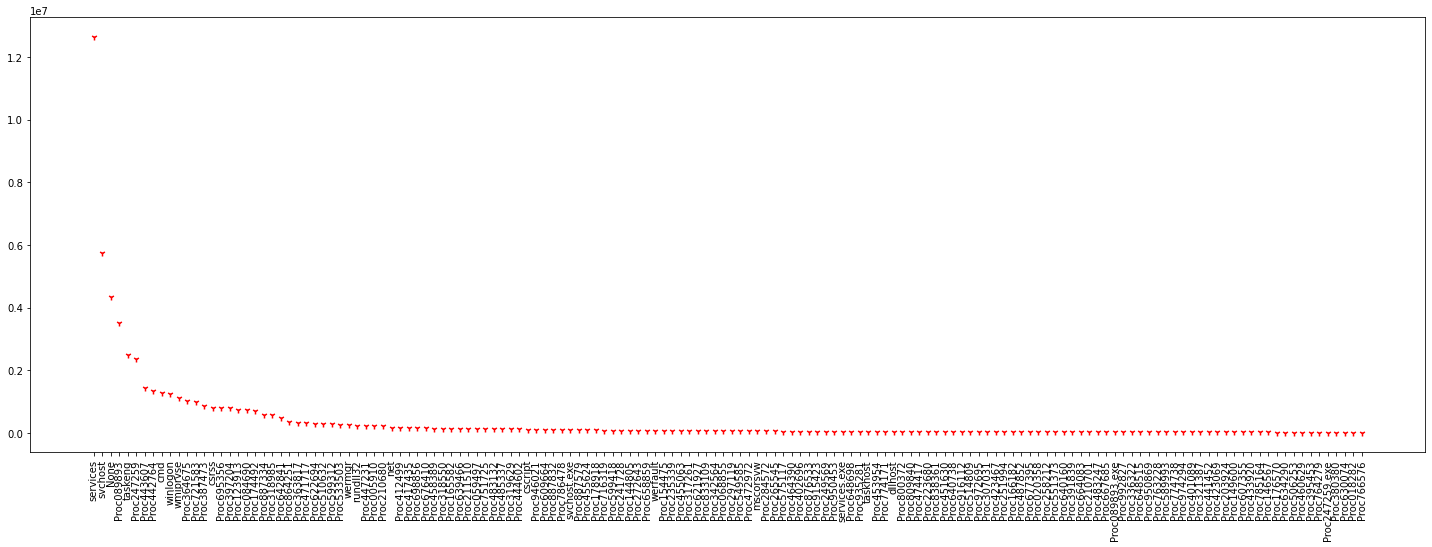

In [50]:
x=counts[3].loc[:,"ParentProcessName"].head(150)
y=counts[3].loc[:,"Count"].head(150)

plt.rcParams["figure.figsize"] = (25,8)
plt.scatter(x,y,marker="1",c="Red")
plt.xticks(rotation=90)
plt.show()

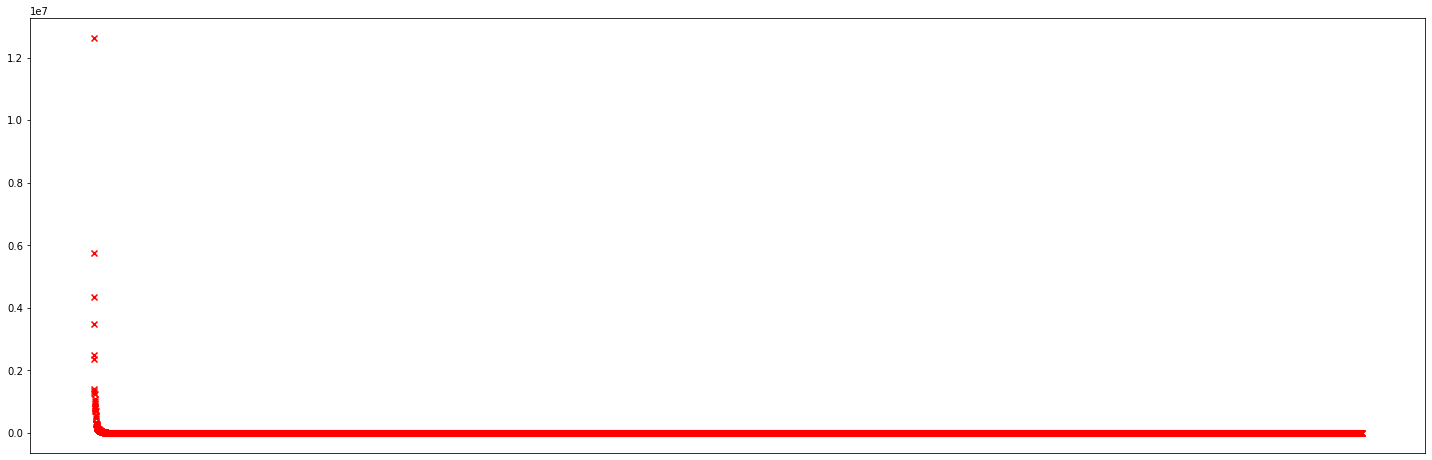

Completed in :0:00:23.105141


In [66]:
dtn()

x=counts[3].loc[:,"ParentProcessName"]
y=counts[3].loc[:,"Count"]

plt.rcParams["figure.figsize"] = (25,8)
plt.scatter(x,y,marker="x",c="Red")
plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.show()

gen_end()

In [32]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                          df_p: 14.5 GiB
                             x:  1.6 MiB
                             z: 899.0 KiB
                             y: 198.0 KiB
                           _19:  1.7 KiB
                           _17:  1.6 KiB
                           _18:  1.6 KiB
                           _20:  1.6 KiB
                            _7:  1.5 KiB
                            _8:  1.5 KiB


In [34]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25320 entries, 0 to 25319
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   UserName  25320 non-null  object
 1   Count     25320 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 395.8+ KB
